# Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
print(tf.__version__)

2.0.0


In [3]:
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12894, 160, 160, 3) (12894,)
(500, 160, 160, 3) (500,)


In [4]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

In [5]:
base_model = applications.MobileNetV2(input_shape=[160, 160, 3], include_top=False,weights=None)
base_model

In [6]:
class Model(models.Model):
    def __init__(self,base_model):
        super(Model,self).__init__()
        self.base_model = base_model
        self.top_layer = models.Sequential([
            layers.Dense(10),
            layers.Activation(tf.nn.softmax),
        ])
        
    def call(self,inputs,training=False):
        x = self.base_model(inputs, training=training)
        x = layers.Flatten()(x)
        outputs = self.top_layer(x, training=training)
        return outputs

In [7]:
model = Model(base_model)
model.build((None, 160, 160, 3))

In [8]:
with open("../model/model_20200507_9_1.00_0.0088", "rb") as f:
    weights = pickle.load(f)

In [9]:
model.set_weights(weights)

# Import foolbox

In [10]:
import foolbox as fb

### Foolbox Models

foolbox를 사용하기 위해서는 텐서플로 모델을 foolbox 모델로 감싸야 한다.

이때, bounds (이미지의 bound, 우리는 이미지 범위가 0~1이므로, \[0, 1\]을 넣어준다)를 설정하고, preprocessing에는 빈 딕셔너리를 넣음

In [11]:
fmodel = fb.TensorFlowModel(model, bounds=[0.0, 1.0], preprocessing=dict())
fmodel

### Foolbox Adversarial Attacks

시험삼아서 deepfool을 l2로 구동하는 공격법을 불러온다(foolbox 안에 있음).

In [12]:
deepfool_l2 = fb.attacks.L2DeepFoolAttack()

공격을 여러번 할 수 있는데, 총 3번 할거다.
각각 perturbation 범위를 0.01, 0.03, 0.1로 설정한다.

In [13]:
epsilons = [0.01, 0.03, 0.1]

공격을 시행해서 adv sample을 생성한다.

In [14]:
advs, _, success = deepfool_l2(fmodel, X_train[:10], y_train[10:20], epsilons=epsilons)
print(type(advs))
print(type(success))

<class 'list'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


0과 1사이로 공격샘플이 만들어졌기 때문에 클리핑은 따로안해도 될듯

In [15]:
advs[0].numpy().max(), advs[0].numpy().min()

(1.0, 0.0)

공격이 성공했는지를 나타낸다. 총 10장을 넣었고, 이 10장을 가지고 3번씩 공격했으니 30개가 나옴

In [16]:
success

<tf.Tensor: id=12025, shape=(3, 10), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])>

### Visualization of Adv Samples

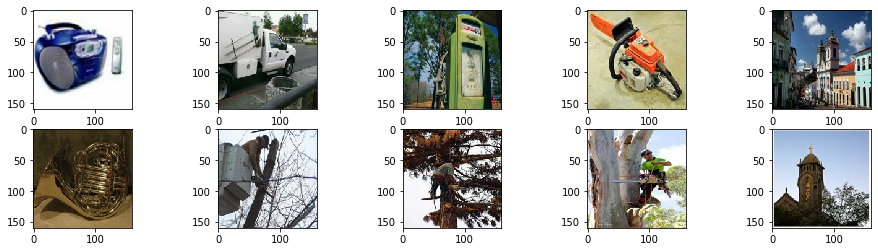

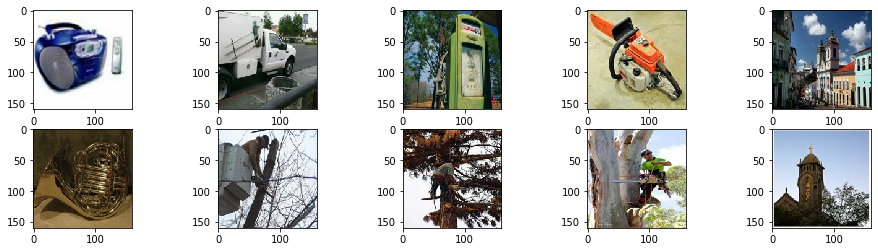

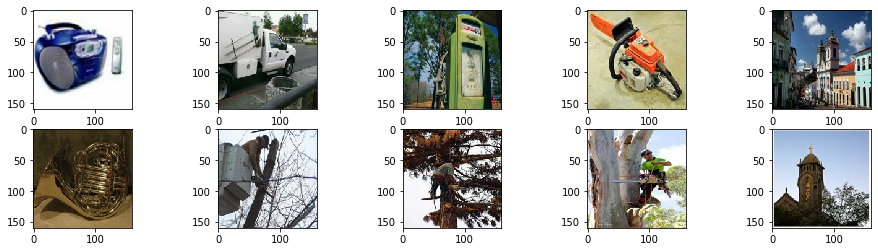

In [17]:
for adv in advs:
    adv = adv.numpy()
    n = adv.shape[0]
    
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(2, 5, i+1)
        plt.imshow(adv[i])
    plt.show()